In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Nadam
from keras.callbacks import EarlyStopping
import numpy as np
from os.path import join
from pickle import load
import shutil

import datetime

In [2]:
print(tf.__version__)
print(keras.__version__)

2.8.0
2.8.0


In [3]:
# Model 생성, compile
modelType = 'Dense'
def create_model():

    model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(4242,)),
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(6000, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4000, activation='relu'),  
    tf.keras.layers.Dense(303, activation='linear'),  
    ])

    return model

learningRate = 0.001
patience = 10
myoptim=Nadam(learning_rate=learningRate, beta_1=0.9, beta_2=0.999, epsilon=1e-07, decay=0.0)
early_stopping = EarlyStopping(monitor='val_loss',patience = patience, mode='min') # 일단은 적당히 epoch 주고 돌리기

# 학습 조건 저장하기
config = dict()
config["model"] = modelType
config['patience'] = patience

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 4242)              0         
                                                                 
 dense (Dense)               (None, 6000)              25458000  
                                                                 
 dropout (Dropout)           (None, 6000)              0         
                                                                 
 dense_1 (Dense)             (None, 4000)              24004000  
                                                                 
 dense_2 (Dense)             (None, 303)               1212303   
                                                                 
Total params: 50,674,303
Trainable params: 50,674,303
Non-trainable params: 0
_________________________________________________________________


In [4]:
# 데이터 셋 준비
dataSetDir = r'Z:\PROJECTS\iwalqq\Data\V3D\Output\IMU Deep Learning\Data\20220325_raw_byDeepak_csv\INC_ByStep\INC_ByZero\Included_checked\SAVE_dataSet'
scalerDir  = r'Z:\PROJECTS\iwalqq\Data\V3D\Output\IMU Deep Learning\Data\20220325_raw_byDeepak_csv\INC_ByStep\INC_ByZero\Included_checked\SAVE_fittedScaler'

# IMU for Joint Angles
- IMU로 joint Angles 추론하기

In [5]:
# 준비된 K-fold data iteration
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# shutil.rmtree('./logs', ignore_errors=True) # 삭제는 신중ㅎ히
# tensorboard 동작시키는 법 : tensorboard --logdir logs/fit
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

epochs = 1000
for numFold in range(0,5): # 5-fold crossvalidation
    print(f"Num of Fold: {numFold}")
    # 데이터 불러오기
    # 모든 데이터는 scaled된 데이터임!
    load_train = np.load(join(dataSetDir,f"{numFold}_fold_final_train.npz"))
    load_test = np.load(join(dataSetDir,f"{numFold}_fold_final_test.npz"))
    print(f'loaded Train shape: {load_train["final_X_train"].shape}, {load_train["final_Y_angle_train"].shape}, {load_train["final_Y_moBWHT_train"].shape}')
    print(f'loaded Test shape: {load_test["final_X_test"].shape}, {load_test["final_Y_angle_test"].shape}, {load_test["final_Y_moBWHT_test"].shape}')
    # sclaer 불러오기
    # Here scaler is MinMaxScaler!
    load_scaler4X = load(open(join(scalerDir,f"{numFold}_fold_scaler4X.pkl"), 'rb'))
    load_scaler4Y_angle = load(open(join(scalerDir,f"{numFold}_fold_scaler4Y_angle.pkl"), 'rb'))
    load_scaler4Y_moBWHT = load(open(join(scalerDir,f"{numFold}_fold_scaler4Y_moBWHT.pkl"), 'rb'))

    # 차원 축소
    X_train = np.squeeze(load_train["final_X_train"], axis=2)
    Y_angle_train = np.squeeze(load_train["final_Y_angle_train"], axis=2)

    X_test = np.squeeze(load_test["final_X_test"], axis=2)
    Y_angle_test = np.squeeze(load_test["final_Y_angle_test"], axis=2)

    # 요건 나중에... [early_stopping,]
    ########################################################
    # 미쳤네! 모델 초기화 빼먹음
    #########################################################
    history = model.fit(X_train, Y_angle_train, validation_data=(X_test,Y_angle_test), epochs=epochs, callbacks=[tensorboard_callback]) 
    break


Num of Fold: 0
loaded Train shape: (722, 4242, 1), (722, 303, 1), (722, 303, 1)
loaded Test shape: (155, 4242, 1), (155, 303, 1), (155, 303, 1)
Epoch 1/1000
23/23 [==============================] - 32s 1s/step - loss: 0.9781 - mae: 0.9781 - val_loss: 0.2004 - val_mae: 0.2004
Epoch 2/1000
23/23 [==============================] - 32s 1s/step - loss: 0.2549 - mae: 0.2549 - val_loss: 0.1266 - val_mae: 0.1266
Epoch 3/1000
23/23 [==============================] - 31s 1s/step - loss: 0.2108 - mae: 0.2108 - val_loss: 0.3186 - val_mae: 0.3186
Epoch 4/1000
23/23 [==============================] - 31s 1s/step - loss: 0.1852 - mae: 0.1852 - val_loss: 0.1187 - val_mae: 0.1187
Epoch 5/1000
23/23 [==============================] - 31s 1s/step - loss: 0.1671 - mae: 0.1671 - val_loss: 0.1323 - val_mae: 0.1323
Epoch 6/1000
23/23 [==============================] - 31s 1s/step - loss: 0.1622 - mae: 0.1622 - val_loss: 0.1865 - val_mae: 0.1865
Epoch 7/1000
23/23 [==============================] - 31s 1s/ste

In [6]:
history

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


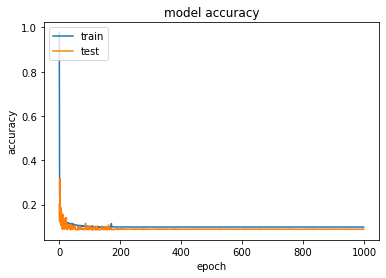

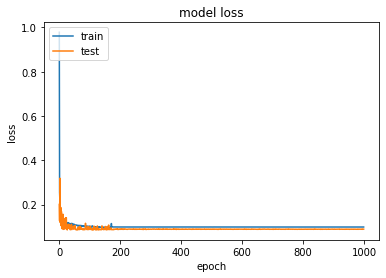

In [10]:
import matplotlib.pyplot as plt
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [11]:
model.save("my_model")

INFO:tensorflow:Assets written to: my_model\assets
